<a href="https://colab.research.google.com/github/mmmarcelom/extrair-pdf/blob/main/Extrair_Dados_de_PDF's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyPDF2

In [ ]:
from PyPDF2 import PdfFileReader
import re

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io
my_pdf = io.BytesIO(uploaded['Precatórios - trf5.pdf'])

In [ ]:
# Create pdf file reader object
pdf = PdfFileReader(my_pdf)

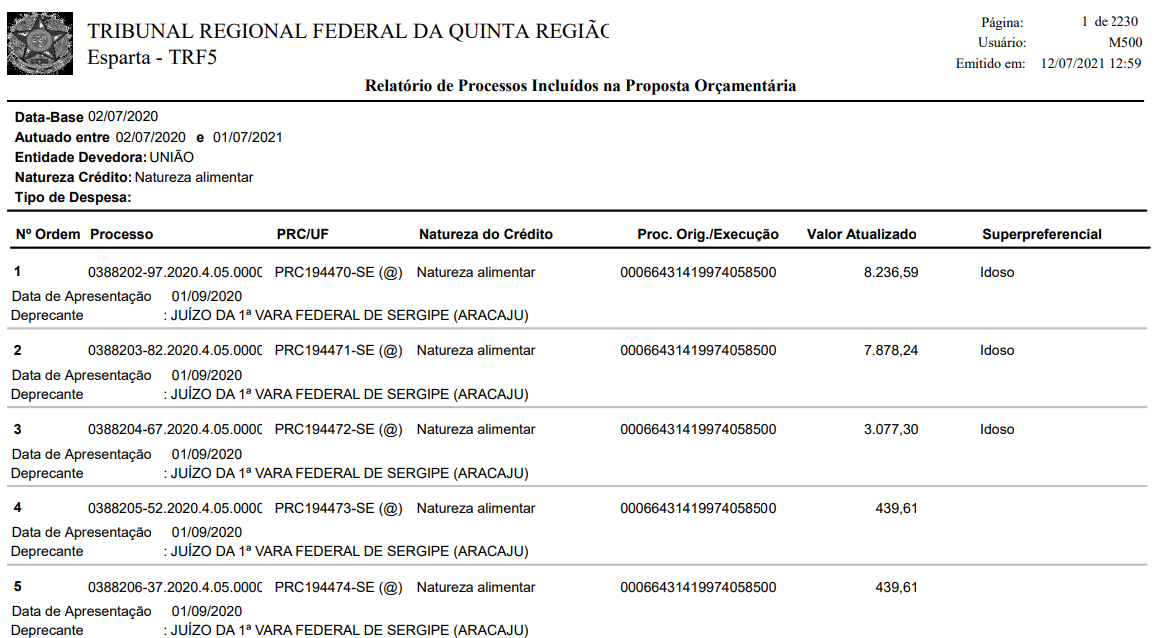

# EXEMPLO DE DADOS DEPOIS DO SPLIT
'',

'0388202-97.2020.4.05.0000',

' PRC194470-SE (@)',
 
' Natureza alimentar',

' 000664314199740585001 8.236,59',

':Deprecante JUÍZO DA 1ª VARA FEDERAL DE SERGIPE (ARAC AJU)',

'',

'Data de Apresentação',

' 01/09/2020 Idoso',

'',

In [ ]:
def ler_pagina(texto):

  palavras = texto.split('\n')
  precatorio = {}
  precatorios = []

  num_proc_pagamento = re.compile('\d{7}\-\d{2}\.\d{4}\.\d\.\d{2}\.0000')
  num_precatorio = re.compile('PRC\d*\-\w\w')
  natureza = re.compile('Natureza')
  num_execucao = re.compile('\d{20}|\d{7}\-\d{2}\.\d{4}\.\d\.\d{2}\.\d{4}')
  valor = re.compile('(\d{1,3}(\.\d{3})*|\d+)(\,\d{2})')
  superpreferencial = re.compile('Doença Grave|Idoso')
  data = re.compile('\d{2}\/\d{2}\/\d{4}')
  juizo = re.compile('Deprecante')
  dataapresentacao = re.compile('Data de Apresentação')

  palavra_anterior = ''

  for palavra in palavras:
  
    if num_proc_pagamento.search(palavra): precatorio['num_proc_pagamento'] = palavra
    if num_precatorio.search(palavra): precatorio['num_precatorio'] = palavra

    # Extrair numero do processo e valor
    if num_execucao.search(palavra):
      numero = num_execucao.search(palavra).group(0)
      if len(numero) == 20:
        precatorio['num_execucao'] = numero[:7] + '-' + numero[7:9] + '.' + numero[9:13] + '.' + numero[13] + '.' + numero[14:16] + '.' + numero[-4:]
      else:
        precatorio['num_execucao'] = num_execucao.search(palavra).group(0)

    if valor.search(palavra): 
      precatorio['valor'] = valor.search(palavra).group(0)

    if juizo.search(palavra): 
      precatorio['juizo'] = palavra.replace(':Deprecante ','')

    # Extrair data e superpreferencial
    if data.search(palavra) and dataapresentacao.search(palavra_anterior):
      precatorio['data'] = data.search(palavra).group(0)
      try:
        precatorio['superpreferencial'] = superpreferencial.search(palavra).group(0)  
      except AttributeError:
        precatorio['superpreferencial'] = 'Nenhum'

    if natureza.search(palavra) and num_precatorio.search(palavra_anterior):
      precatorio['natureza'] = palavra

    #A palavra anterior é útil para garantir que estamos extraindo a data e natureza corretamente
    palavra_anterior = palavra

    # Se todos os dados foram encontrados, encerra o precatório e inicia um novo
    if len(precatorio.keys()) == 8: 
      precatorios.append(precatorio.copy())
      precatorio.clear()
  
  if len(precatorio.keys()) > 0: precatorios.append(precatorio.copy())
  return precatorios

In [ ]:
# Extraindo apenas de uma página
precatorios_lista = []

texto = pdf.getPage(823).extractText()

precatorios_lista.extend(ler_pagina(texto))
precatorios_lista

In [ ]:
# Extraindo do PDF inteiro

precatorios_lista = []

#for page in pdf.pages: # Não sei dizer porque isso não funciona
for i in range(pdf.getNumPages()):
#for i in range(9):

  texto = pdf.getPage(i).extractText()
  precatorios_lista.extend(ler_pagina(texto))
  
  print(f'Página {i+1}: {len(precatorios_lista)}')

In [ ]:
precatorios_lista[-1]

In [ ]:
import pandas as pd

df = pd.DataFrame(data=precatorios_lista)
df

In [ ]:
from google.colab import files

df.to_csv('output.csv', encoding = 'utf-8-sig', sep = ";") 
files.download('output.csv')